In [7]:
import pgmpy
import pandas as pd

from pgmpy import config, estimators


In [8]:
# Import csv to pandas dataframe
df_complete = pd.read_csv('dataset_whitaker.csv')

# Select only the variables used in the R script of Whitaker et al. (2020)
df = df_complete[["HI_UPTAKE","SCHOOLS", "SBI", "MC", "CCY", "SM"]]
df.head()

,HI_UPTAKE,SCHOOLS,SBI,MC,CCY,SM
0,1,2,1,0,0,0
1,1,2,1,0,0,0
2,1,2,1,0,0,0
3,1,2,1,0,1,1
4,1,1,1,1,0,0


In [38]:
pc_estimation = estimators.PC(data=df).estimate(variant = 'stable', max_cond_vars = 15, return_type = "cpdag", significance_level = 0.10)


Working for n conditional variables: 2:  13%|█▎        | 2/15 [00:00<00:00, 68.17it/s]


In [39]:
import networkx as nx
import matplotlib.pyplot as plt

In [40]:
G = nx.Graph()
G.add_edges_from(pc_estimation.edges())

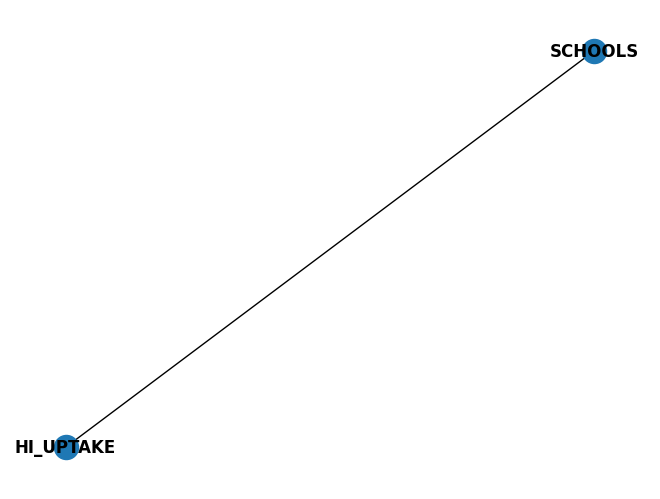

In [41]:
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

In [42]:
est = estimators.MmhcEstimator(data=df)
dag = est.estimate()

  0%|          | 0/1000000 [00:00<?, ?it/s]


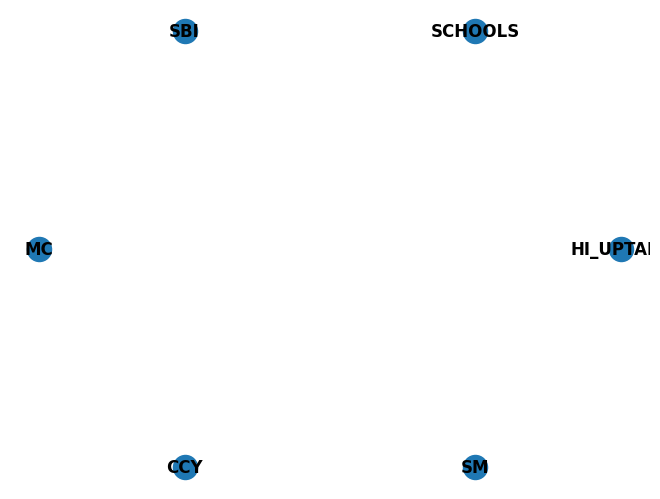

In [43]:
nx.draw_kamada_kawai(dag, with_labels=True, font_weight='bold')
plt.show()

In [44]:
est = estimators.ExhaustiveSearch(data=df)

In [17]:
#dag = est.estimate()  # This one is very heavy

In [ ]:
nx.draw_kamada_kawai(dag, with_labels=True, font_weight='bold')
plt.show()

In [9]:
from pgmpy.estimators import CITests

# Conditional Independence Tests

Here I just test the conditional independencies implied by the causal graph of Whitaker et al. (2020) preferred model.
Letting $S$ for 'SCHOOLS', $Y$ for 'CCY', and $U$ for 'HI_UPTAKE', recall that the paper finds:
$$S = 2 + S = 1 * Y = 0 ↔ U = 1$$

This can be put into a causal graph, since it imples that $S → U$ and $Y → U$, and no causal link was found between $S$ and $Y$:
$$S → U ← Y$$

Furthermore, now we can take this causal graph and calculate its associated conditional independencies.
We can compute the CIs in this case by hand quickly, thanks to the rules of d-separation on *colliders*:

+ $¬(U\; \_||\_\; S)$
+ $¬(U\; \_||\_\; Y)$
+ $(S\; \_||\_\; Y)$
+ $¬(S\; \_||\_\; Y | S)$

In parallel, we can also compute the conditional independencies from the data set.
Contrasting both sets of conditional independencies will then tell us whether CNA and interventionism arrive at the same causal conclusions, or not.

`pgmpy.estimators.CITests` provides different algorithms to compute conditional independencies in a dataset.
All of these *test the null hypothesis that* $X\; \_||\_\; Y \; | \; Z$ and output `True` or `False`.
Note that $Z$ can be the empty set.
See the [official documentation](https://pgmpy.org/structure_estimator/pc.html#module-pgmpy.estimators.CITests).


In [16]:
data = df_complete

for citest in [CITests.chi_square, CITests.cressie_read, CITests.freeman_tuckey]:
    u_ci_s = citest(X='HI_UPTAKE', Y='SCHOOLS', Z=[], data=data, significance_level=0.05)
    u_ci_y = citest(X='HI_UPTAKE', Y='CCY', Z=[], data=data, significance_level=0.05)
    s_ci_y = citest(X='SCHOOLS', Y='CCY', Z=[], data=data, significance_level=0.05)
    s_ci_y_cond_u = citest(X='SCHOOLS', Y='CCY', Z=['HI_UPTAKE'], data=data, significance_level=0.05)

    print(f"\n{citest.__name__}:")
    print(f"on U _||_ S: {u_ci_s}")
    print(f"on U _||_ Y: {u_ci_y}")
    print(f"on S _||_ Y: {s_ci_y}")
    print(f"on S _||_ Y | U: {s_ci_y_cond_u}")

print()



chi_square:
on U _||_ S: False
on U _||_ Y: True
on S _||_ Y: True
on S _||_ Y | U: True

cressie_read:
on U _||_ S: False
on U _||_ Y: True
on S _||_ Y: True
on S _||_ Y | U: True

freeman_tuckey:
on U _||_ S: False
on U _||_ Y: True
on S _||_ Y: True
on S _||_ Y | U: True



/home/alebg/Investigación/21- PhD UNIGE/Cases/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:8073: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/home/alebg/Investigación/21- PhD UNIGE/Cases/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:8073: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
